<a href="https://colab.research.google.com/github/ontenkutsenko/RL_Autonomous_Driving/blob/main/Individual%20Notebooks/Sol3%2B4Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Final Project

Welcome to your Reinforcement Learning project! Join in groups of a maximum of 5 students on a project focused on developing an RL agent capable of solving an environment for decision-making in Autonomous Driving. The project deadline has been set to the 2nd of June.

Autonomous Driving has long been considered a field in which RL algorithms excel, and this project aims to leverage the power of RL to create an intelligent agent that can solve the Farama’s foundation “highway-env” project, namely the Highway environment (refer to https://highway-env.farama.org/environments/highway/).

## Project Requirements:

* The environments observation’s format can vary according to our preference, namely Kinematics, Grayscale Image, Occupancy grid and Time to collision (refer to https://highway-env.farama.org/observations/). In your solutions you should use 2 of these types.
* The agents actions can also vary, as continuous actions, discrete actions and discrete meta-actions (refer to https://highway-env.farama.org/actions/). In your solutions you should use 2 of these types.
* As for the algorithms to use, any algorithm is valid (seen or not in class), with a minimum requirement of 3 different algorithms used.
* Apart from the environment observation types and agent action types you must use environment’s configuration provided in the annexed notebook!
Note: Your delivery should comprise 4 solutions to the highway environment (corresponding to the combinations of the two environment observation’s types and the two agent’s action types), in which you just need to use one algorithm for each combination (knowing that you need to use at least 3 different algorithms).


## Project Objectives:

* Train an RL agent to solve the Highway environment: The primary objective of this project is to develop an RL agent that can maximize the reward given by the highway environment (refer to https://highway-env.farama.org/rewards/), which leverages to maximize speed while minimizing crash risk!
* Optimize decision-making using RL algorithms: Explore different RL algorithms to train the agent. Compare and analyse their effectiveness in learning and decision-making capabilities in the context of the environment.
* Explore and expand on the reward system: Although you should evaluate your agent with the reward function provided by the environment, you could/should expand it to better train your agent.
* Enhance interpretability and analysis: Develop methods to analyse the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.



### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.
* Explore multi agent approaches: The environment allows you to use more than one agent per episode. Explore multi agent alternatives to improve your learning times and overall benchmarks.


## Imports Required

You might need to restart the kernel after installation

In [ ]:
#!pip install gymnasium highway-env stable-baselines3[extra]

In [1]:
import gymnasium as gym

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm
import itertools
import pickle
import random
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from gymnasium.spaces import Discrete, Box
from stable_baselines3 import A2C
import torch
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Functions.kinematics_discrete import Kinematics, Q_learning, SARSA, Algorithm
from Functions.funcs_kinematics_discrete import get_params

import warnings
import logging

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='gymnasium')

# Set logging level to ERROR
logging.getLogger().setLevel(logging.ERROR)

## Solution 1
Environment Observation Type: tweaked kinematics\
Agent Action Type: discrete meta actions\
Algorithm Used: Q-Learning and SARSA

##### Using manual control to understand how good the state danger represents the actual danger of the car

In [ ]:
kinematics_test = Kinematics(seed=10, 
                state_type='danger', 
                render_mode='human', 
                sim_frequency=20, 
                policy_frequency=5, 
                danger_threshold_x=12.5, 
                danger_threshold_y=12.5,   # Changed to 12.5 from 10, bc the driver takes time to notice other cars on the right 
                x_speed_coef=1,
                y_speed_coef=1,
                collision_reward=-50,
                high_speed_reward=0,
                reward_speed_range=[20, 30],
                to_right_reward=5, 
                to_right_skewness=2, 
                change_lane_reward=-1,
                lane_tolerance=2)

kinematics_test.test_env(show_values=True, manual=True, debug=True)

##### Random search for the best hyperparameters

In [ ]:
parameter_ranges = {
    'alphas': np.arange(0.05, 0.2, 0.025),  
    'eps_decays': np.arange(0.95, 0.99, 0.005), 
    'sim_frequencies': [20], 
    'policy_frequencies': [1, 2, 3, 4],
    'gammas': np.arange(0.8, 1.0, 0.025),
    'x_speed_coefs': np.arange(0.9, 1.5, 0.05), 
    'y_speed_coefs': np.arange(0.5, 0.9, 0.1),
    'danger_threshold_xs' : np.arange(10, 20, 2),
    'danger_threshold_ys': np.arange(10, 20, 2),
    'past_action_len' : np.arange(2, 4, 1)
}

for i in range(20): 
    selected_parameters = {key: random.choice(value) for key, value in parameter_ranges.items()}
    print(selected_parameters)

    Q = Q_learning(
        print_stats=True, 
        epsilon=1,
        epsilon_decay=selected_parameters['eps_decays'],
        min_epsilon=0.1,
        alpha=selected_parameters['alphas'],
        gamma=selected_parameters['gammas'],
        state_type='danger', 
        policy_frequency=selected_parameters['policy_frequencies'],    
        sim_frequency=selected_parameters['sim_frequencies'],   
        danger_threshold_x=selected_parameters['danger_threshold_xs'],
        danger_threshold_y=selected_parameters['danger_threshold_ys'],
        x_speed_coef=selected_parameters['x_speed_coefs'],
        y_speed_coef=selected_parameters['y_speed_coefs'],
        lane_tolerance=2,
        collision_reward=-100,
        high_speed_reward=10,
        reward_speed_range=[20, 30],
        to_right_reward=15,
        to_right_skewness=8,
        change_lane_reward=-1,
        special_Q=True, 
        past_action_len=int(selected_parameters['past_action_len'])
)  

    Q.train(m=200, max_steps=150, verbose=0, show_progress=300, render=False)

    print(np.mean(Q.rewards_hist_compare[-40:]))

    Q.save()

##### Displaying the results of the search

In [ ]:
# Go to the domain saved_models and load the models 
models = ['model_Q_learning_20240611-1522.pkl',
          'model_Q_learning_20240611-2133.pkl', 
          'model_Q_learning_20240611-2248.pkl', 
          'model_Q_learning_20240611-2346.pkl', 
          'model_Q_learning_20240612-0056.pkl',
          'model_Q_learning_20240612-0149.pkl',
          'model_Q_learning_20240612-0430.pkl',
          'model_Q_learning_20240612-1229.pkl', 
          'model_Q_learning_20240612-1434.pkl', 
          'model_Q_learning_20240612-1606.pkl', 
          'model_Q_learning_20240612-1721.pkl'
          ]

parameters = {}
evaluations = {}
for model in models:
    model_Q = Q_learning.load(f'Models/{model}')
    Q_dict = model_Q.Q.copy()
    Q = Algorithm(Q=Q_dict, special_Q=True)
    mean_reward, mean_step, mean_reward_per_step, mean_speed = Q.evaluate(iterations=10, render=False)
    model_name = model.split('_')[-1].split('.')[0]
    evaluations[model_name] = (mean_reward, mean_step, mean_reward_per_step, mean_speed)
    parameters[model_name] = model_Q.__dict__

# Save the evaluations
with open('Evaluation/Kinematics_dis/evaluations.pkl', 'wb') as f:
    pickle.dump(evaluations, f)

In [2]:
# Load the evaluations
with open('Evaluation/Kinematics_dis/evaluations.pkl', 'rb') as f:
    evaluations = pickle.load(f)

# Get the best model based on the mean reward
best_model = max(evaluations, key=lambda x: evaluations[x][0])
print(best_model)

# Load the best model
model_Q = Q_learning.load(f'Models/model_Q_learning_{best_model}.pkl')

20240611-1522


##### Example training of a model

In [3]:
# Get the parameters of the best model. This is done because the last model was from another version of the code
params = get_params(model_Q)
Q_model = Q_learning(**params)

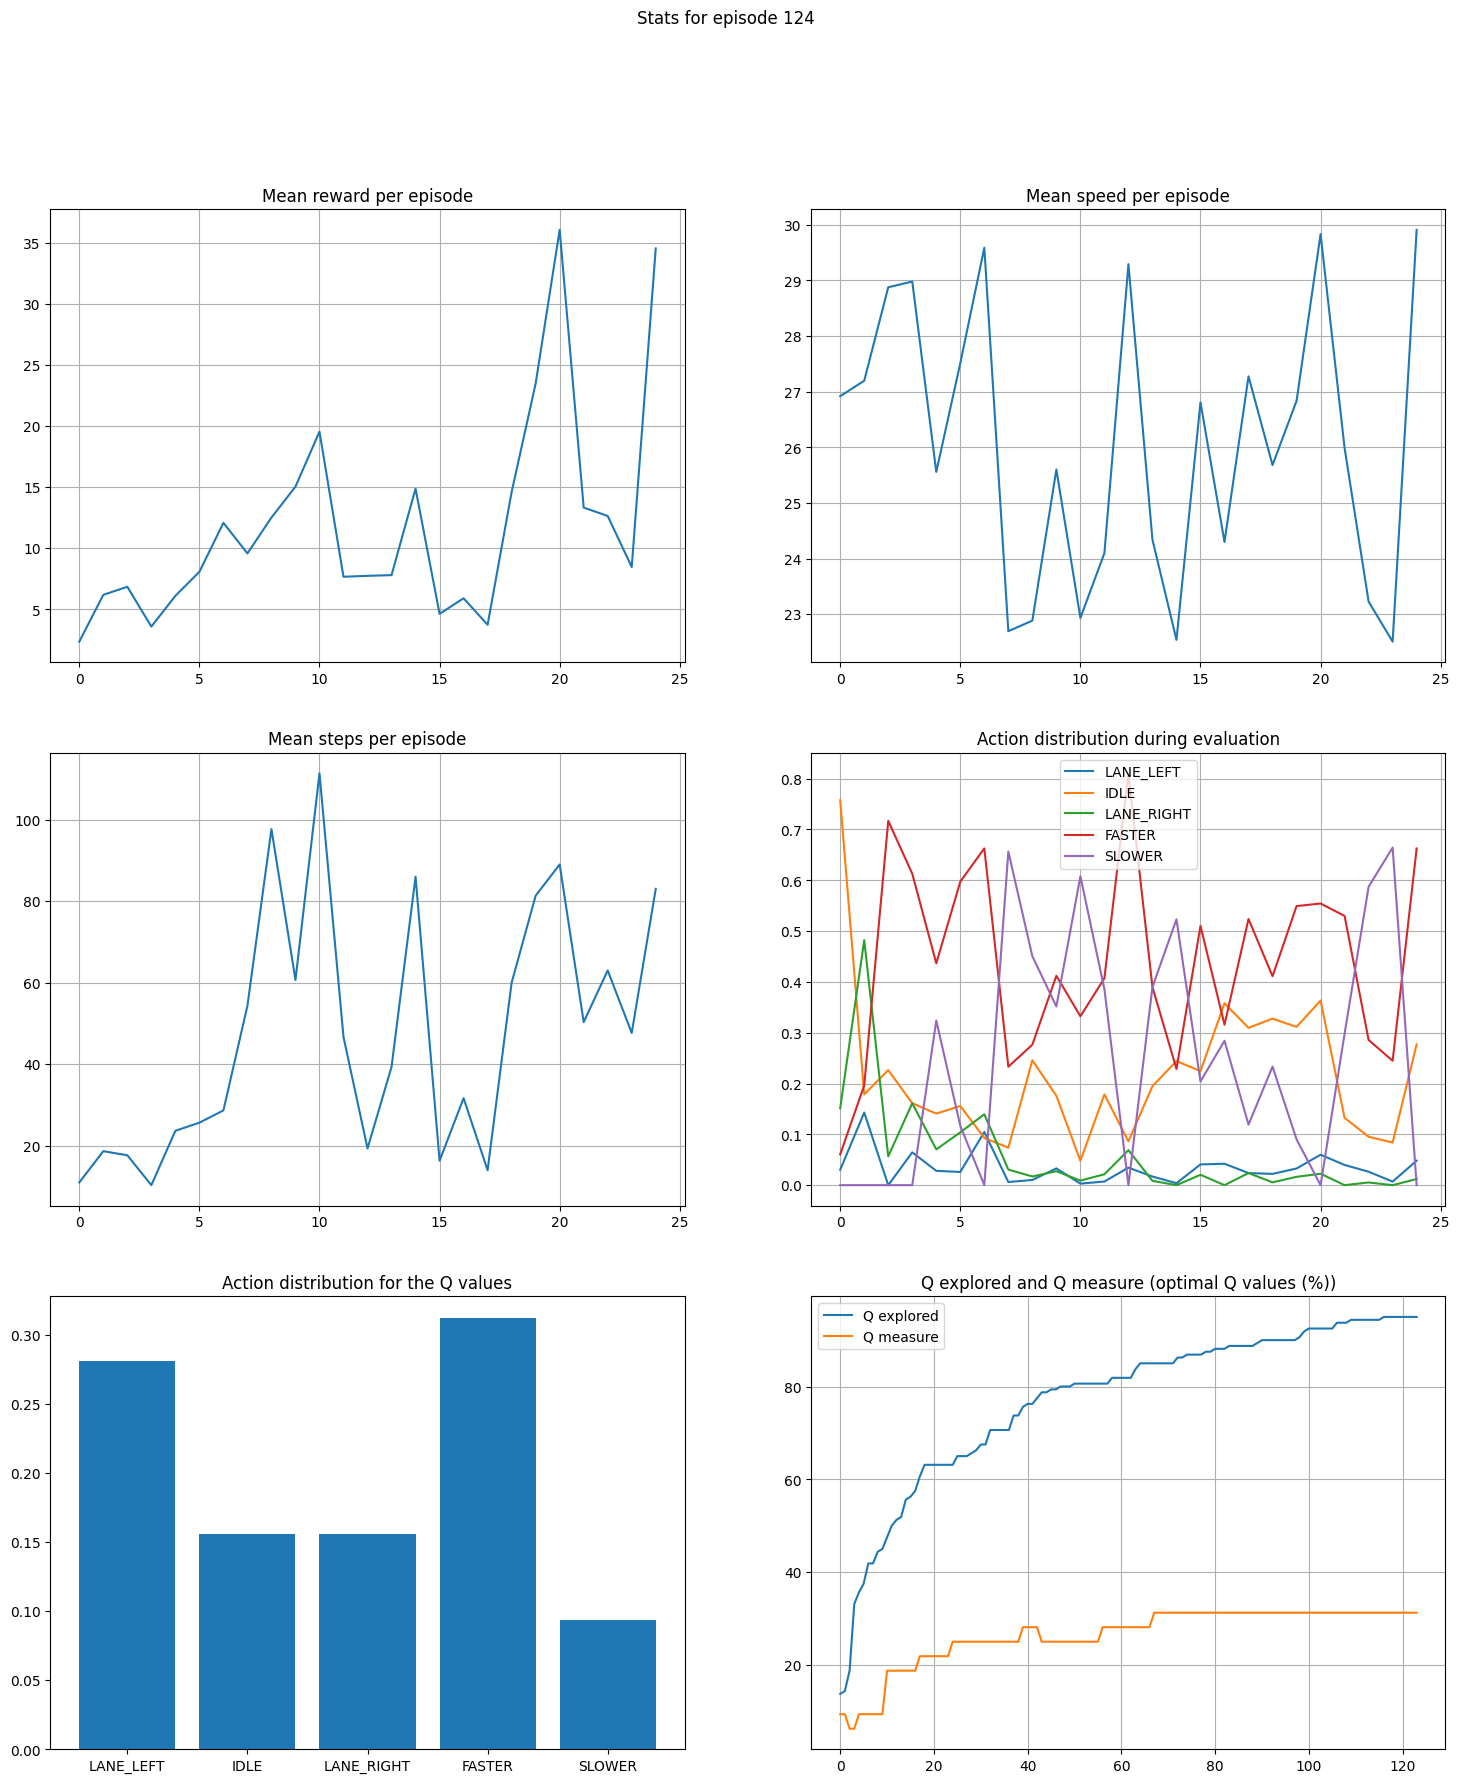

In [4]:
Q_model.train(m=125, max_steps=150, verbose=0, show_progress=5, render=False)

##### Testing the model visually

In [ ]:
model_Q.test(sleep_time=0)

## Solution 2
Environment Observation Type: time to collision\
Agent Action Type: ContinuousActions (Discretized)\
Algorithm Used: DQN

## Solution 3
Environment Observation Type: Kinematics\
Agent Action Type: ContinuousActions (Discretized)\
Algorithm Used: DQN

In [17]:
continuous_action_configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,  # Maximum duration of each episode in seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
    },
    "action": {
        "type": "DiscreteAction",
        "actions_per_axis": 5,
        "steering_range": [-np.pi / 4, np.pi / 4],
        "acceleration_range": [-5, 5],
        "speed_range": [1, 30]
    },
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
    "high_speed_reward": 0.4,
    "lane_change_reward": 0.2,
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
}

base_env = gym.make('highway-v0', config=continuous_action_configuration, render_mode='human')

In [18]:
class NegativeVelocityPenaltyWrapper(gym.RewardWrapper):
    def __init__(self, env, penalty):
        super(NegativeVelocityPenaltyWrapper, self).__init__(env)
        self.penalty = penalty

    def reward(self, reward):
        # Get the agent's velocity
        velocity = self.env.vehicle.velocity[0]  # Assuming the velocity is the first feature
        if velocity < 0:
            reward += self.penalty
        return reward

In [19]:
#env = NegativeVelocityPenaltyWrapper(base_env, penalty=-0.05)
env = make_vec_env(lambda: base_env, n_envs=1)

In [ ]:
original_env = env.envs[0]
def print_action_meanings(env):
    action_type = env.action_type
    cont_space = action_type.space()
    low = np.array([-1, -1])
    high = np.array([1, 1])
    axes = np.linspace(low, high, action_type.actions_per_axis).T
    all_actions = list(itertools.product(*axes))
    for i, action in enumerate(all_actions):
        acceleration = np.interp(action[0], [-1, 1], action_type.acceleration_range)
        steering = np.interp(action[1], [-1, 1], action_type.steering_range)
        print(f"Action {i}: Acceleration {acceleration:.2f}, Steering {steering:.2f}")

print_action_meanings(original_env)

Action 0: Acceleration -5.00, Steering -0.79
Action 1: Acceleration -5.00, Steering -0.39
Action 2: Acceleration -5.00, Steering 0.00
Action 3: Acceleration -5.00, Steering 0.39
Action 4: Acceleration -5.00, Steering 0.79
Action 5: Acceleration -2.50, Steering -0.79
Action 6: Acceleration -2.50, Steering -0.39
Action 7: Acceleration -2.50, Steering 0.00
Action 8: Acceleration -2.50, Steering 0.39
Action 9: Acceleration -2.50, Steering 0.79
Action 10: Acceleration 0.00, Steering -0.79
Action 11: Acceleration 0.00, Steering -0.39
Action 12: Acceleration 0.00, Steering 0.00
Action 13: Acceleration 0.00, Steering 0.39
Action 14: Acceleration 0.00, Steering 0.79
Action 15: Acceleration 2.50, Steering -0.79
Action 16: Acceleration 2.50, Steering -0.39
Action 17: Acceleration 2.50, Steering 0.00
Action 18: Acceleration 2.50, Steering 0.39
Action 19: Acceleration 2.50, Steering 0.79
Action 20: Acceleration 5.00, Steering -0.79
Action 21: Acceleration 5.00, Steering -0.39
Action 22: Acceleratio

In [20]:
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.avg_rewards = []

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> None:
        episode_reward = sum(self.locals['infos'][0]['episode']['r'] for i in range(len(self.locals['infos'])) if 'episode' in self.locals['infos'][i])
        if episode_reward:
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(len(self.locals['infos']))
            avg_reward = np.mean(self.episode_rewards[-100:])  # Average of last 100 episodes
            self.avg_rewards.append(avg_reward)

callback = RewardLoggerCallback()

In [ ]:
model = DQN('MlpPolicy', env, verbose=1)

Using cpu device


In [ ]:
model.learn(total_timesteps=30000, callback=callback)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40       |
|    ep_rew_mean      | 4.79     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 121      |
|    total_timesteps  | 160      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0694   |
|    n_updates        | 14       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40       |
|    ep_rew_mean      | 4.1      |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 242      |
|    total_timesteps  | 320      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0201   |
|    n_updates      

In [22]:
save_path = "Models"
os.makedirs(save_path, exist_ok=True)
model_file = os.path.join(save_path, "dqn_current_new")

# Save the trained model
#model.save(model_file)
model = DQN.load(model_file, custom_objects={"observation_space": env.observation_space, "action_space": env.action_space})

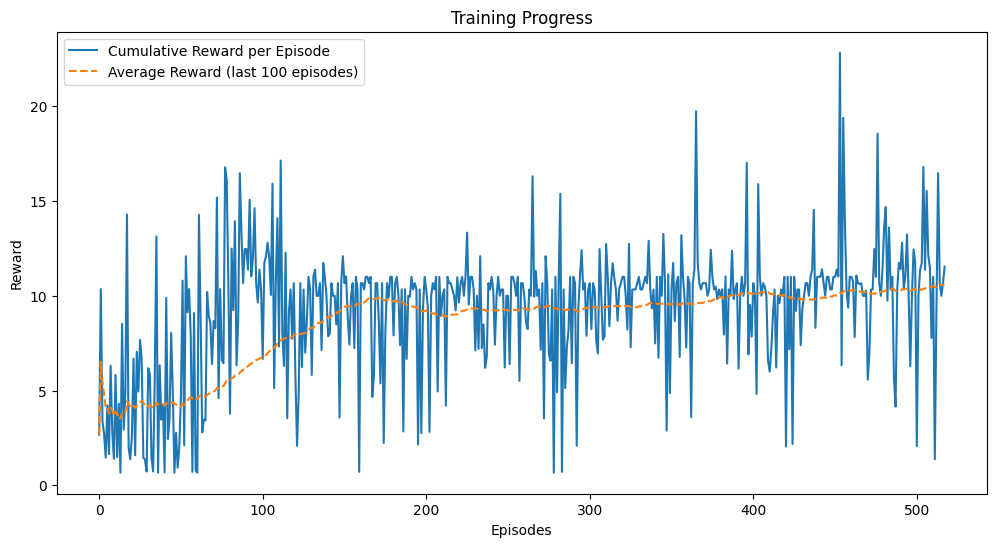

In [ ]:
# Plotting cumulative and average rewards
plt.figure(figsize=(12, 6))
plt.plot(callback.episode_rewards, label='Cumulative Reward per Episode')
plt.plot(callback.avg_rewards, label='Average Reward (last 100 episodes)', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.show()

#### Evaluation

In [ ]:
default_config = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 100,  # [s]
    "collision_reward": -1,  # Default collision reward
    "right_lane_reward": 0.1,  # Default right lane reward
    "high_speed_reward": 0.4,  # Default high speed reward
    "lane_change_reward": 0,   # Default lane change reward
    "reward_speed_range": [20, 30],
    "normalize_reward": True,  # Enable normalization
    "offroad_terminal": False,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"]
    },
    "action": {
        "type": "DiscreteAction",
        "actions_per_axis": 5,
        "steering_range": [-np.pi / 4, np.pi / 4],
        "speed_range": [1, 30],
        "acceleration_range": [-5, 5]
    },
}

# Create the environment with custom configuration for training
env = make_vec_env(lambda: gym.make('highway-v0', config=default_config), n_envs=1)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: 26.011157400000002 +/- 12.668754316232114


In [ ]:
# Evaluate the agent
episode_rewards = []
average_speeds = []
episode_lengths = []
all_velocities = []
actions = []
episode_velocities_list = []

obs = env.reset()
for episode in range(5):
    done = False
    episode_reward = 0
    total_speed = 0
    steps = 0
    episode_velocities = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(int(action))
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        speed = np.linalg.norm(obs[0][2:])
        total_speed += speed
        steps += 1
        episode_velocities.append(speed)

    average_speeds.append(total_speed / steps)
    episode_lengths.append(steps)
    episode_rewards.append(episode_reward)
    all_velocities.extend(episode_velocities)
    episode_velocities_list.append(episode_velocities)
    obs = env.reset()

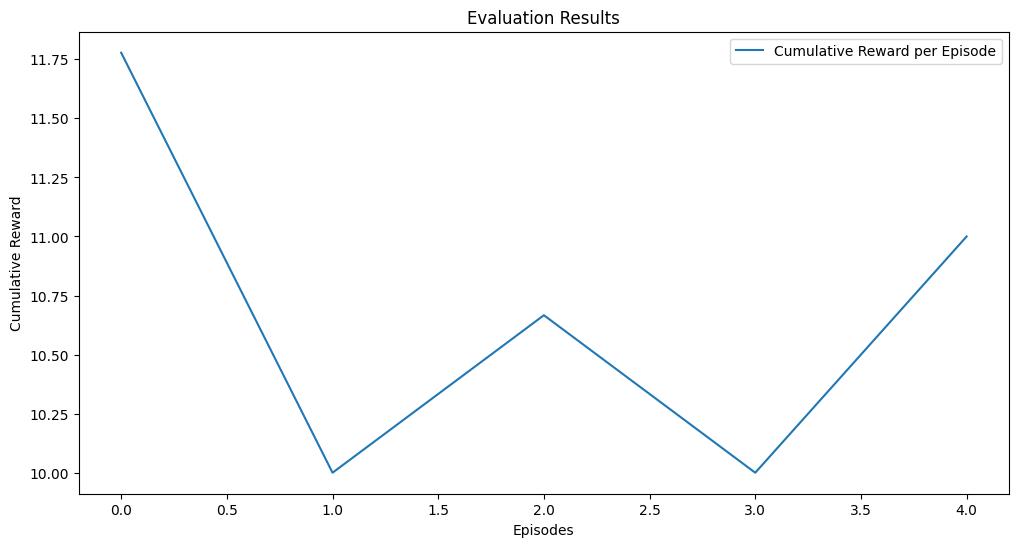

Average Speed: 0.10667328989505767


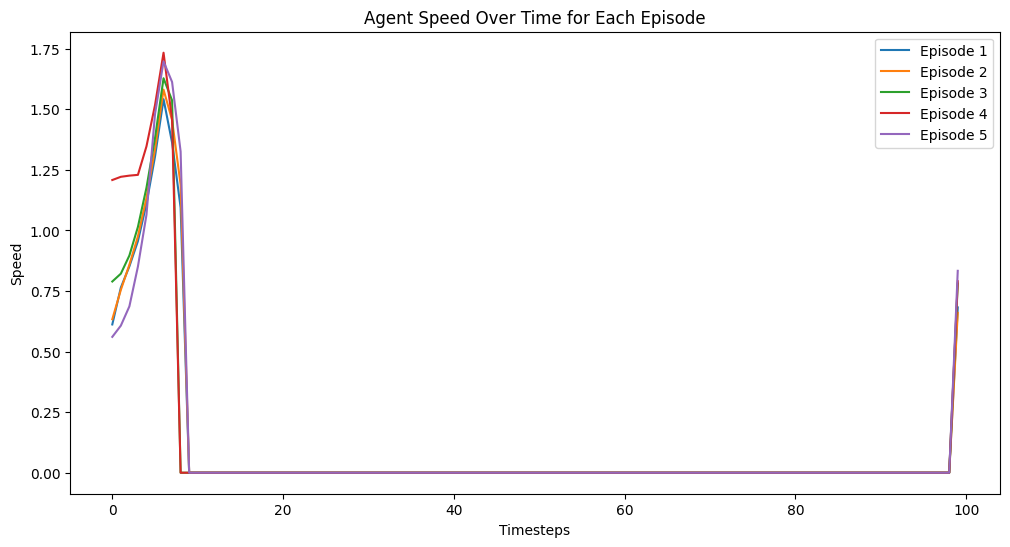

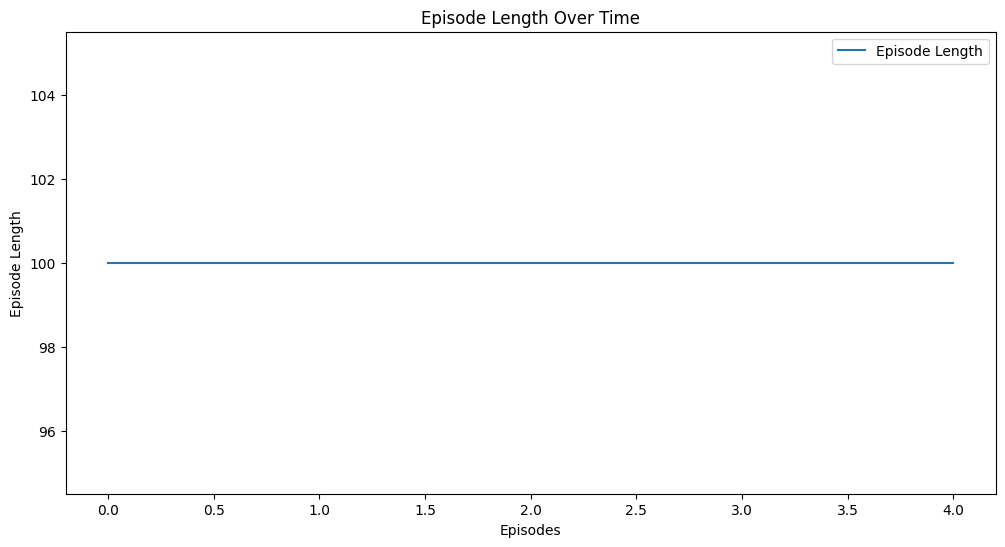

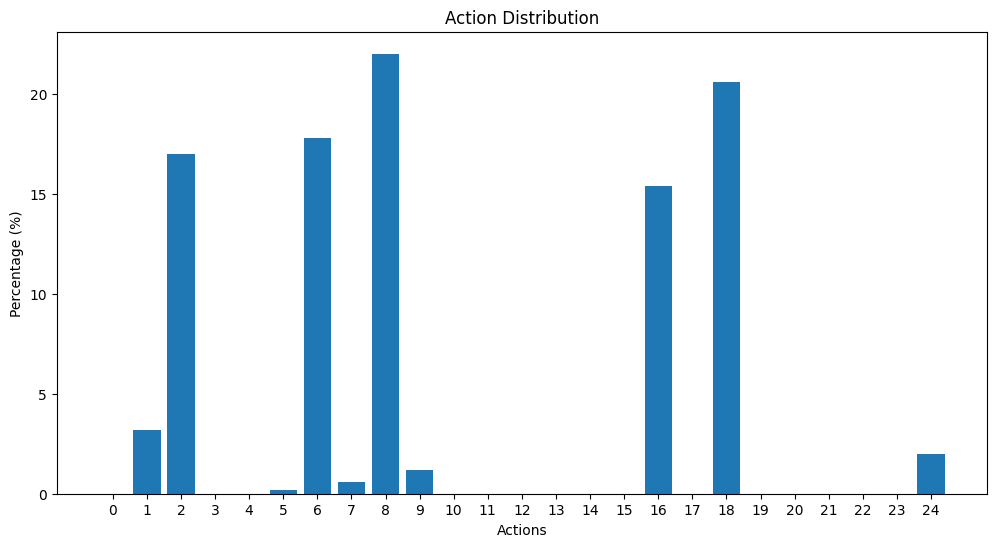

In [ ]:
# Plot evaluation results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Cumulative Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Evaluation Results')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"Average Speed: {np.mean(average_speeds)}")


# Plotting velocities over time for each episode
plt.figure(figsize=(12, 6))
for idx, episode_velocities in enumerate(episode_velocities_list):
    plt.plot(episode_velocities, label=f'Episode {idx + 1}')
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Agent Speed Over Time for Each Episode')
plt.legend()
plt.show()

# Plotting episode lengths
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths, label='Episode Length')
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('Episode Length Over Time')
plt.legend()
plt.show()

# Plotting action distribution
action_counts = np.bincount(actions, minlength=env.action_space.n)
action_percentages = action_counts / len(actions) * 100

plt.figure(figsize=(12, 6))
plt.bar(range(env.action_space.n), action_percentages, tick_label=np.arange(env.action_space.n))
plt.xlabel('Actions')
plt.ylabel('Percentage (%)')
plt.title('Action Distribution')
plt.show()


## Solution 4
Environment Observation Type: Kinematics\
Agent Action Type: ContinuousActions\
Algorithm Used: A2C

In [2]:
continuous_action_configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,  # Maximum duration of each episode in seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
    },
    "action": {
        "type": "ContinuousAction",
        "steering_range": [-np.pi / 4, np.pi / 4],
        "acceleration_range": [-5, 5],
        "speed_range": [1, 30]
    },
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
}

base_env = gym.make('highway-v0', config=continuous_action_configuration)

In [3]:
env = make_vec_env(lambda: base_env, n_envs=1)

In [4]:
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.actions = []
        self.positions = []
        self.velocities = []
        self.collisions = []
        self.lane_changes = []

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> None:
        episode_reward = sum(self.locals['infos'][0]['episode']['r'] for i in range(len(self.locals['infos'])) if 'episode' in self.locals['infos'][i])
        if episode_reward:
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(len(self.locals['infos']))
            for info in self.locals['infos']:
                if 'action' in info:
                    self.actions.append(info['action'])
                if 'observation' in info:
                    self.positions.append(info['observation'][:2])
                    self.velocities.append(info['observation'][2:])
                if 'collision' in info:
                    self.collisions.append(info['collision'])
                if 'lane_change' in info:
                    self.lane_changes.append(info['lane_change'])

callback = RewardLoggerCallback()

In [ ]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=30000, callback=callback)

Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 40       |
|    ep_rew_mean        | 5.6      |
| time/                 |          |
|    fps                | 1        |
|    iterations         | 100      |
|    time_elapsed       | 373      |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.87    |
|    explained_variance | -1.29    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.147    |
|    std                | 1.02     |
|    value_loss         | 0.00461  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 40       |
|    ep_rew_mean        | 4.06     |
| time/                 |          |
|    fps                | 1        |
|    iterations         | 200      |
|    time_elapsed       | 748      |
|    total_timesteps 

In [8]:
save_path = "Models"
os.makedirs(save_path, exist_ok=True)
model_file = os.path.join(save_path, "a2c_current_new")

# Save the trained model
#model.save(model_file)
model = A2C.load(model_file, custom_objects={'observation_space': env.observation_space, 'action_space': env.action_space})

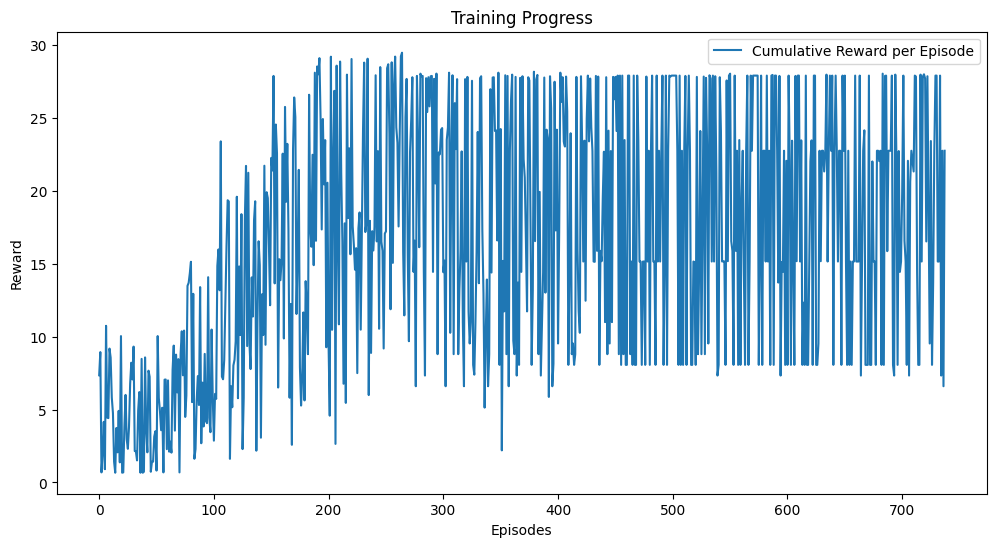

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(callback.episode_rewards, label='Cumulative Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.show()

#### Evaluation

In [ ]:
continuous_action_configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 100,  # Maximum duration of each episode in seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
    },
    "action": {
        "type": "ContinuousAction",
        "steering_range": [-np.pi / 4, np.pi / 4],
        "acceleration_range": [-5, 5],
        "speed_range": [1, 30]
    },
    "collision_reward": -1,
    "reward_speed_range": [20, 30],
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
}

env = gym.make('highway-v0', config=continuous_action_configuration)
env = make_vec_env(lambda: env, n_envs=1)

In [ ]:
# evaluate the agent with the function provided by stable-baselines3
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: 44.986666400000004 +/- 16.25499025057297


In [ ]:
# Evaluate the agent
episode_rewards = []
episode_lengths = []
average_speeds = []
all_velocities = []
episode_velocities_list = []

obs = env.reset()
for episode in range(5):
    done = False
    episode_reward = 0
    total_speed = 0
    steps = 0
    episode_velocities = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        speed = np.linalg.norm(obs[0][2:])
        total_speed += speed
        steps += 1
        episode_velocities.append(speed)

    average_speeds.append(total_speed / steps)
    episode_lengths.append(steps)
    episode_rewards.append(episode_reward)
    all_velocities.extend(episode_velocities)
    episode_velocities_list.append(episode_velocities)
    obs = env.reset()

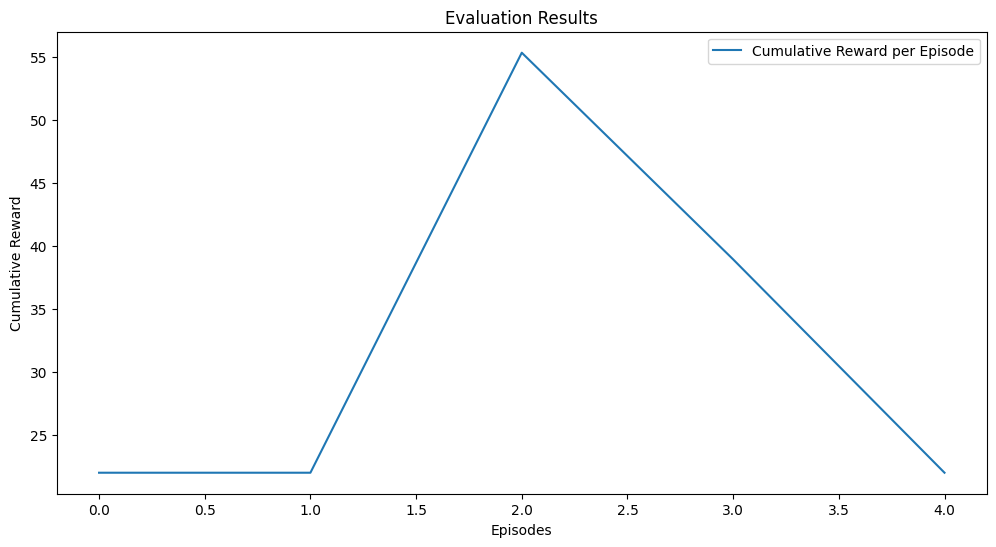

Average Speed: 0.12959507548809052


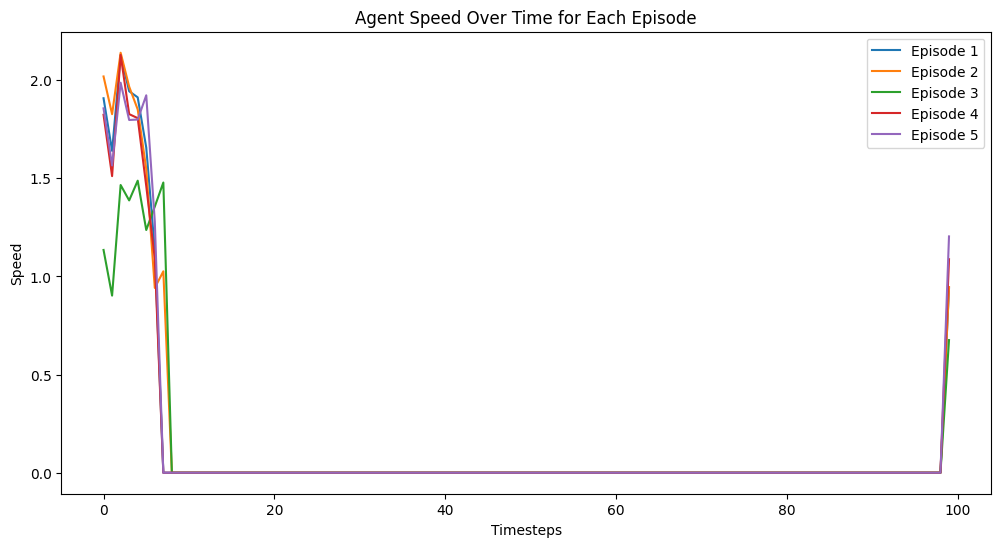

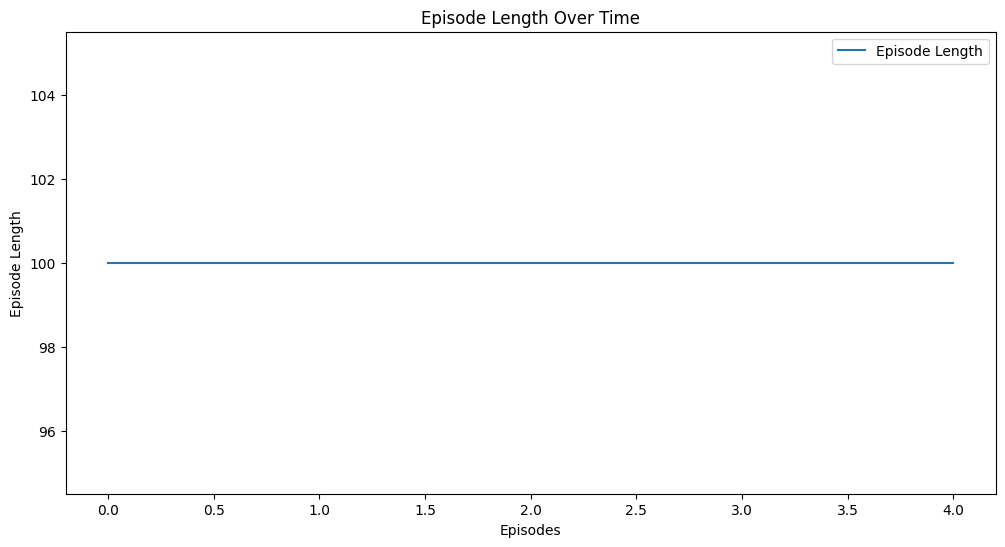

In [ ]:
# Plot evaluation results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Cumulative Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Evaluation Results')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"Average Speed: {np.mean(average_speeds)}")

# Plotting velocities over time for each episode
plt.figure(figsize=(12, 6))
for idx, episode_velocities in enumerate(episode_velocities_list):
    plt.plot(episode_velocities, label=f'Episode {idx + 1}')
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Agent Speed Over Time for Each Episode')
plt.legend()
plt.show()

# Plotting episode lengths
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths, label='Episode Length')
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('Episode Length Over Time')
plt.legend()
plt.show()